In [1]:
import os

import torch as th
import torch.nn as nn
import pandas as pd
from braindecode.models import EEGNetv4
from skorch import NeuralNet
from sampling import get_sampling_fn
from huggingface_hub import hf_hub_download

from data_utils.data_utils import Sampling
from data_utils.dataset import Lee2019Dataset, EEGDataset
from metrics import Metrics
from data_utils.plot_util import Plotting
from framework import SDEFramework

In [2]:
EMA = True
from configs.Lee2019_ERP_CFG import (
    DATASET_CFG,
    MODEL_CFG,
    RUN_CFG,
    SAMPLING_CFG,
)

Reading /nvme1/xiejy/projects/Conditional-EEG-Diffusion-main/datasets/Lee2019_ERP-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     992.19 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
66240 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 4 columns


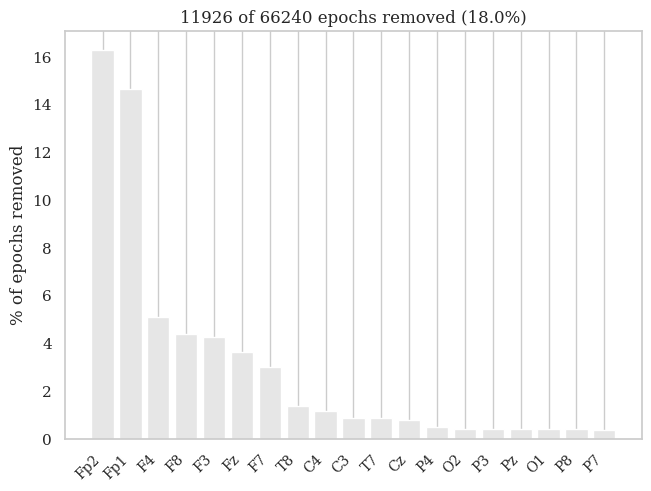

In [3]:
amplitude_latency_channel = "O1"

dataset = Lee2019Dataset(**DATASET_CFG)

In [4]:
sampling_fn_cfg = {
    "sampler_name": "pc",
    "predictor_name": "euler_maruyama",
    "corrector_name": "langevin",
    "noise_removal": True,
    "probability_flow": False,
    "snr": 0.16,
    "n_steps_each": 1,
    "eps": 1e-5,
}

In [5]:
# model_ckpt = hf_hub_download(
#     repo_id="guido151/checkpoints",
#     filename="EEGWave_step600000/model.ckpt",
# )
model_ckpt = "/home/xiejy/nvme1/projects/Conditional-EEG-Diffusion-main/EEGWave_step600000/model.ckpt"

In [6]:
combination = pd.DataFrame(
    {
        "label": ['Target', "NonTarget"],
        "subject": [2, 2],
        "session": ['session_1', 'session_1'],
    }
)

In [7]:
# if one wants to sample the full dataset:
# combination = dataset.conditionals_combinations

# dataset=dataset
# amplitude_latency_channel=amplitude_latency_channel
# model_ckpt=model_ckpt
# EMA=EMA
# sampling_fn_cfg=sampling_fn_cfg
# combination=combination

In [8]:
framework = SDEFramework.load_from_checkpoint(model_ckpt)

/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:51: The loaded checkpoint was produced with Lightning v2.0.9, which is newer than your current Lightning version: v2.0.4


In [9]:
sampling_fn = get_sampling_fn(
    framework.sde,
    sampling_fn_cfg["sampler_name"],
    sampling_fn_cfg["predictor_name"],
    sampling_fn_cfg["corrector_name"],
    sampling_fn_cfg["noise_removal"],
    sampling_fn_cfg["snr"],
    sampling_fn_cfg["n_steps_each"],
    sampling_fn_cfg["probability_flow"],
    framework.hparams.continuous,
    framework.hparams.device,
    sampling_fn_cfg["eps"],
)

In [10]:
if isinstance(DATASET_CFG["user_conditions"], list):
    MODEL_CFG["model__conditionals_combinations"] = dataset.condition_combinations

In [11]:
# load pre-trained EEGNet
path_params = "/home/xiejy/nvme1/projects/Conditional-EEG-Diffusion-main/EEGNetv4_Lee2019_ERP/params.pt"
path_optimizer = "/home/xiejy/nvme1/projects/Conditional-EEG-Diffusion-main/EEGNetv4_Lee2019_ERP/optimizer.pt"
path_history = "/home/xiejy/nvme1/projects/Conditional-EEG-Diffusion-main/EEGNetv4_Lee2019_ERP/history.json"
path_criterion = "/home/xiejy/nvme1/projects/Conditional-EEG-Diffusion-main/EEGNetv4_Lee2019_ERP/criterion.pt"

In [12]:
model = EEGNetv4(
    n_chans=19,
    n_outputs=2,
    n_times=128,
)

net = NeuralNet(
    model,
    criterion=nn.CrossEntropyLoss(weight=th.tensor([1, 1])),
)
net.initialize()
net.load_params(
    path_params,
    path_optimizer,
    path_criterion,
    path_history,
)

In [13]:
metrics = Metrics(
    dataset.X,
    net.module,
    amplitude_latency_channel,
    DATASET_CFG["fmin"],
    DATASET_CFG["fmax"],
)

/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
plotting = Plotting(
    SAMPLING_CFG["plot_channels"],
)

In [15]:
sampling = Sampling(
    dataset.X,
    sampling_fn,
    dataset.mne_info,
    metrics,
    plotting,
    combination,
    SAMPLING_CFG["split_condition"],
    dataset.reverse_mapping,
    dataset.y_df,
)

       label
0     Target
1  NonTarget
   subject    session
0        2  session_1


Not setting metadata
3869 matching events found
No baseline correction applied
Not setting metadata
3869 matching events found
No baseline correction applied
['generated: non-target' 'real: non-target' 'generated: target'
 'real: target']


/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nvme1/xiejy/envs/eeg-diffusion/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

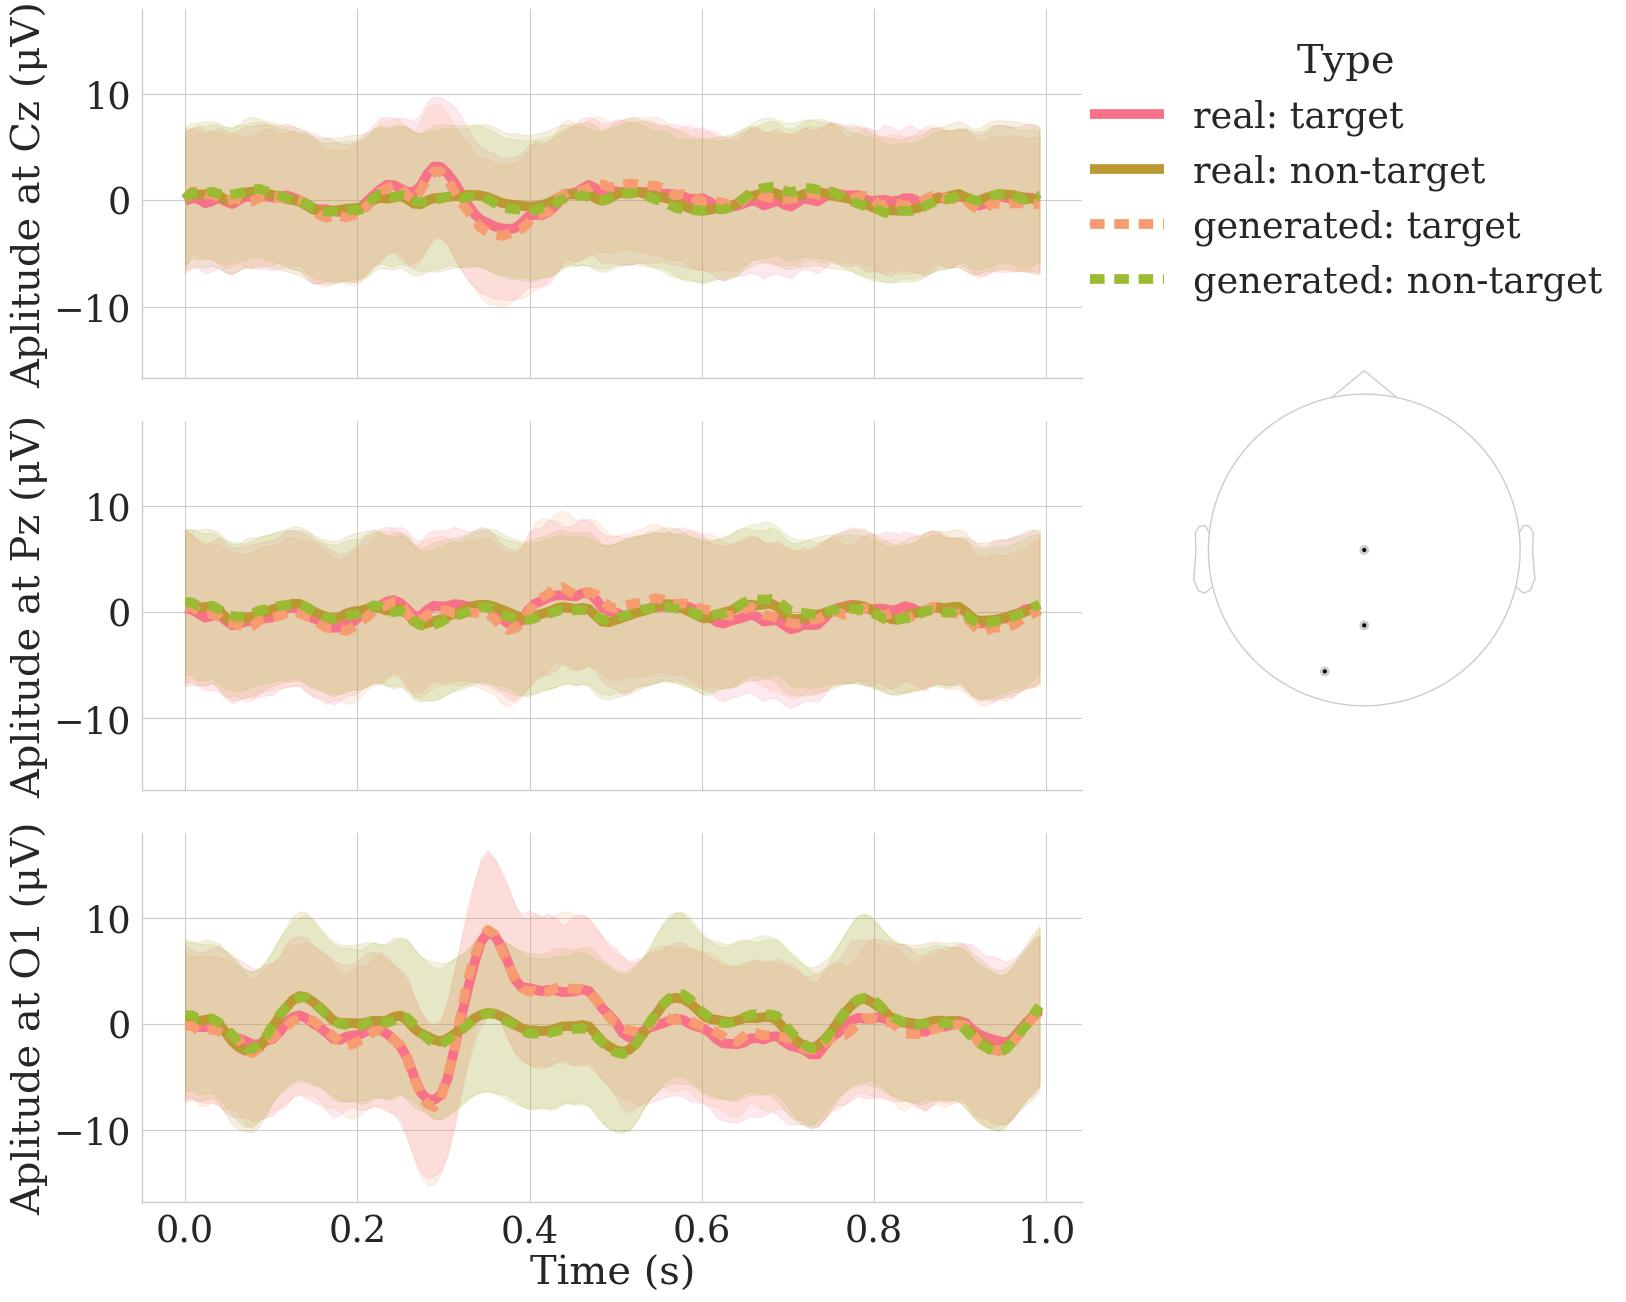

In [16]:
# set model to eval mode
framework.eval()
with th.no_grad():
    sampling_model = framework.ema_model if EMA else framework.model

    sampling.sampling_logging(
        pl_module=framework,
        sampling_shape=framework.hparams.sampling_shape,
        sampling_model=sampling_model,
    )